# CPTS 475 Final Project

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from sys import getsizeof
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from statistics import mean, median

# Part One
## Classification of Washington State (All Counties)

In [2]:
# WARNING: Large data set.
f = pd.read_csv('Fires.csv', low_memory=False)

In [3]:
# Raw Data comes from: https://www.fs.usda.gov/rds/archive/Catalog/RDS-2013-0009.4/
# Spatial wildfire occurrence data for the United States, 1992-2015
#f.head(5)
#f[f['FOD_ID'] == 300348377]

In [4]:
# pandas drop columns using list of column names and drop NaNs
f2 = f.drop(['FPA_ID','SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'OWNER_CODE', 'OWNER_DESCR', 'FOD_ID' ], axis=1).dropna()

In [5]:
# delete fires large data frame, so it does not overflow Jupyter Notebook
del f

In [6]:
# Size of object (bytes)
#getsizeof(f2) / 1024 / 1024

In [44]:
# helper functions that create additional attribute columns 

# breack down fires into groups according to its region code number (only applies to codes in WA, all other state fires are dopped first)
def get_region(code):
    nw_codes = [73,55,57,29,61,7,33,47,17,37]
    sw_codes = [9,31,35,45,27,49,69,67,53,41,15,11,59,39,77]
    e_codes = [19,65,63,43,25,1,75,23,13,3,71,21,5,51]
    
    if code in nw_codes:
        return 'NW'
    elif code in sw_codes:
        return 'SW'
    elif code in e_codes:
        return 'E'
    else:
        return '?'

In [45]:
# fromats original year and month column into a different format 
def get_yrmo(dstr):
    mdy = dstr.split()[0].split('/')
    mdy = [int(val) for val in mdy]
    if mdy[2] > 20:
        mdy[2] += 1900
    else:
        mdy[2] += 2000
    #YYYYMM
    return mdy[2]*100 + mdy[0]

In [46]:
# formats date into different format 
def get_date(dstr):
    mdy = dstr.split()[0].split('/')
    mdy = [int(val) for val in mdy]
    if mdy[2] > 20:
        mdy[2] += 1900
    else:
        mdy[2] += 2000
    return dt.date(mdy[2], mdy[0], mdy[1])

In [47]:
# Apply functions above and add columns to all US state fire.txt data
f2['START_DATE'] = f2['DISCOVERY_DATE'].apply(get_date)
f2['END_DATE'] = f2['CONT_DATE'].apply(get_date)
f2['DURATION'] = f2['END_DATE'] - f2['START_DATE']
f2['LST_YRMO'] = f2['DISCOVERY_DATE'].apply(get_yrmo)

# get only washington state regions
f2 = f2[f2['STATE'] == 'WA']
# apply get region function to only WA counties
f2['REGION'] = f2['FIPS_CODE'].apply(get_region)

In [48]:
# creates new column/attribute of each region
f_nw = f2[f2['REGION'] == 'NW']
f_sw = f2[f2['REGION'] == 'SW']
f_e = f2[f2['REGION'] == 'E']

In [49]:
# checks the length total of fires of each region column
[len(f_nw), len(f_sw), len(f_e)]

[4247, 3187, 2841]

In [50]:
# x = list(f2['DURATION'])
# x = [day.days for day in x]
# f3 = pd.DataFrame(f2['FIRE_SIZE_CLASS'])
# f3['DURATION'] = f2['DURATION']
# classes = set(f3['FIRE_SIZE_CLASS'])
# props = [(c, len(f3.loc[ f3['FIRE_SIZE_CLASS'] == c ]) / total) for c in classes]
# props = dict(props)
# for key in sorted(props):
#     print("%s: %s" % (key, props[key]))
# class_totals = [(total * value) for value in sorted(props.values())]
# class_totals.reverse()
# total_zero = sum([d == 0 for d in x])
# f3['DURATION'] = x
# d0 = f3.loc[f3['DURATION'] == 0]
# dA = d0.loc[d0['FIRE_SIZE_CLASS'] == 'A']
# total_zero_and_C = [len(d0.loc[d0['FIRE_SIZE_CLASS'] == c]) for c in classes]
# total_zero_and_C.sort(reverse=True)
# relative_props = [a / b for (a,b) in zip(total_zero_and_C, class_totals)]

In [51]:
# OPEN monthly average weather data of Darrington, Spokane, Quincy counties and turn them into dataframes
# U.S. Regional Climate Reference Network (USCRN/USRCRN) via anonymous ftp at: ftp://ftp.ncdc.noaa.gov/pub/data/uscrn/products/monthly01
#NW
darr = pd.read_fwf('CRNM0102-WA_Darrington_21_NNE.txt', header=0)
darr.columns =['WBANNO', 'LST_YRMO', 'CRX_VN_MONTHLY', 'PRECISE_LONGITUDE','PRECISE_LATITUDE', 'T_MONTHLY_MAX', 'T_MONTHLY_MIN', 'T_MONTHLY_MEAN', 'T_MONTHLY_AVG', 'P_MONTHLY_CALC', 'SOLRAD_MONTHLY_AVG', 'SUR_TEMP_MONTHLY_TYPE', 'SUR_TEMP_MONTHLY_MAX', 'SUR_TEMP_MONTHLY_MIN', 'SUR_TEMP_MONTHLY_AVG']

#SW
quin = pd.read_fwf('CRNM0102-WA_Quinault_4_NE.txt', header=None)
quin.columns =['WBANNO', 'LST_YRMO', 'CRX_VN_MONTHLY', 'PRECISE_LONGITUDE','PRECISE_LATITUDE', 'T_MONTHLY_MAX', 'T_MONTHLY_MIN', 'T_MONTHLY_MEAN', 'T_MONTHLY_AVG', 'P_MONTHLY_CALC', 'SOLRAD_MONTHLY_AVG', 'SUR_TEMP_MONTHLY_TYPE', 'SUR_TEMP_MONTHLY_MAX', 'SUR_TEMP_MONTHLY_MIN', 'SUR_TEMP_MONTHLY_AVG']

#E
spok = pd.read_fwf('CRNM0102-WA_Spokane_17_SSW.txt', header=None)
spok.columns =['WBANNO', 'LST_YRMO', 'CRX_VN_MONTHLY', 'PRECISE_LONGITUDE','PRECISE_LATITUDE', 'T_MONTHLY_MAX', 'T_MONTHLY_MIN', 'T_MONTHLY_MEAN', 'T_MONTHLY_AVG', 'P_MONTHLY_CALC', 'SOLRAD_MONTHLY_AVG', 'SUR_TEMP_MONTHLY_TYPE', 'SUR_TEMP_MONTHLY_MAX', 'SUR_TEMP_MONTHLY_MIN', 'SUR_TEMP_MONTHLY_AVG'] 

In [52]:
# MERGE weather dataframes with fire dataframes
nw = pd.merge(f_nw, darr, on=['LST_YRMO','LST_YRMO'])
#nw

sw = pd.merge(f_sw, quin, on=['LST_YRMO','LST_YRMO'])
#sw

e = pd.merge(f_e, spok, on=['LST_YRMO','LST_YRMO'])
#e

# CONCATENATE both fire.txt (only WA) and weather data into one big dataframe
frames = [nw, sw, e]

all_frames = pd.concat(frames, axis=0)
all_frames
#all_frames.dropna()

# DROP unessesary data columns from final dataframe
all_reg = all_frames.drop(['FIRE_NAME','START_DATE','END_DATE','DURATION','COUNTY','STATE','CONT_DOY', 'LATITUDE', 'LONGITUDE', 'FIRE_SIZE', 'CONT_TIME', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'T_MONTHLY_MAX', 'T_MONTHLY_MIN', 'SUR_TEMP_MONTHLY_MAX', 'SUR_TEMP_MONTHLY_MIN', 'WBANNO','SUR_TEMP_MONTHLY_TYPE', 'STAT_CAUSE_CODE', 'FIRE_YEAR', 'CRX_VN_MONTHLY', 'SOLRAD_MONTHLY_AVG', 'T_MONTHLY_MEAN', 'PRECISE_LONGITUDE', 'PRECISE_LATITUDE'], axis=1)
#all_reg['LONGITUDE']
#all_reg['PRECISE_LONGITUDE']
all_reg.head(10)

FIRE_SIZE_CLASS  FIPS_CODE  FIPS_NAME  LST_YRMO REGION  T_MONTHLY_AVG  \
0               A       61.0  Snohomish    200505     NW           13.8   
1               A       33.0       King    200505     NW           13.8   
2               A       33.0       King    200505     NW           13.8   
3               A       37.0   Kittitas    200505     NW           13.8   
4               A       47.0   Okanogan    200505     NW           13.8   
5               A        7.0     Chelan    200505     NW           13.8   
6               A        7.0     Chelan    200505     NW           13.8   
7               A       47.0   Okanogan    200505     NW           13.8   
8               A       47.0   Okanogan    200505     NW           13.8   
9               B        7.0     Chelan    200505     NW           13.8   

   P_MONTHLY_CALC  SUR_TEMP_MONTHLY_AVG  
0            98.9                  14.7  
1            98.9                  14.7  
2            98.9                  14.7  
3            98.9                  14.7  
4            98.9                  14.7  
5            98.9                  14.7  
6            98.9                  14.7  
7            98.9                  14.7  
8            98.9                  14.7  
9            98.9                  14.7

In [55]:
# FIND county in WA will largest number of fires (between 1995-2015)
# FIPS_CODE is in [1,77]
code_set = set(all_reg['FIPS_CODE'])
max_fire_county = (0, 0)
for code in code_set:
    fire_count = len(all_reg[all_reg['FIPS_CODE'] == code])
    if fire_count > max_fire_county[1]:
        max_fire_county = (code, fire_count)
print(max_fire_county)

# RESULT Okanogan county has most fires.

(47.0, 1210)


In [56]:
# Data Frame of Okanogan County Fires
#ok_fires = all_reg[all_reg['FIPS_CODE'] == 47.0]
#ok_fires.head(10)

In [18]:
# Check if we got all class fire sizes
#class_set = list(set(ok_fires['FIRE_SIZE_CLASS']))
#class_set.sort()
#print(class_set)

#Type of LST_YRMO
#ok_fires['LST_YRMO'].dtypes

In [19]:
# check the frequency of all fires class sizes
#class_freq = [(fire_class, len(ok_fires[ok_fires['FIRE_SIZE_CLASS'] == fire_class])) for fire_class in class_set]
#print(class_freq)

In [20]:
# Get percentage of all classes for the county
#class_rel_freq = [(fire_class, round(len(ok_fires[ok_fires['FIRE_SIZE_CLASS'] == fire_class]) / 1210, 4)) for fire_class in class_set]
#print(class_rel_freq)

In [21]:
# Gather and merge Wind Speed data for OKanogan County
# Gathered the wind speed of Okagonan county from Wolfram Alpha data base
#wind_spd = pd.read_csv('ok_wspd.csv')
#wind_spd.head(10)

# Merge wind_spd data frame with data frame of Okanogan County Fires
#ok_county = pd.merge(ok_fires, wind_spd, on=['LST_YRMO','LST_YRMO'])

#ok_county.head(10)

In [57]:
# get rid of any values that are lower than zero
all_reg = all_reg[all_reg.T_MONTHLY_AVG > -1000]
all_reg = all_reg[all_reg.P_MONTHLY_CALC > -1000]

# Check for min values for each feature
min(all_reg["P_MONTHLY_CALC"])
min(all_reg["T_MONTHLY_AVG"])
min(all_reg["SUR_TEMP_MONTHLY_AVG"])

-4.0

In [58]:
# Scale histo distributions all three atttributes to be binomial
all_reg["T_MONTHLY_AVG"] = all_reg["T_MONTHLY_AVG"] - min(all_reg["T_MONTHLY_AVG"]) + 1
all_reg["P_MONTHLY_CALC"] = (all_reg["P_MONTHLY_CALC"] + 1).apply(np.log)
all_reg["SUR_TEMP_MONTHLY_AVG"] = all_reg["SUR_TEMP_MONTHLY_AVG"] - min(all_reg["SUR_TEMP_MONTHLY_AVG"]) + 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e25bee430>]],
      dtype=object)

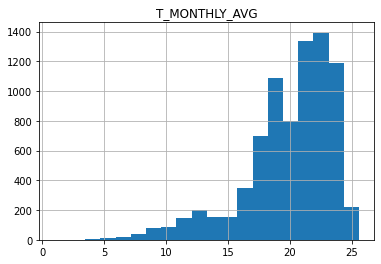

In [59]:
# Get Histo of monthly temp average
all_reg.hist(column="T_MONTHLY_AVG", bins=20)

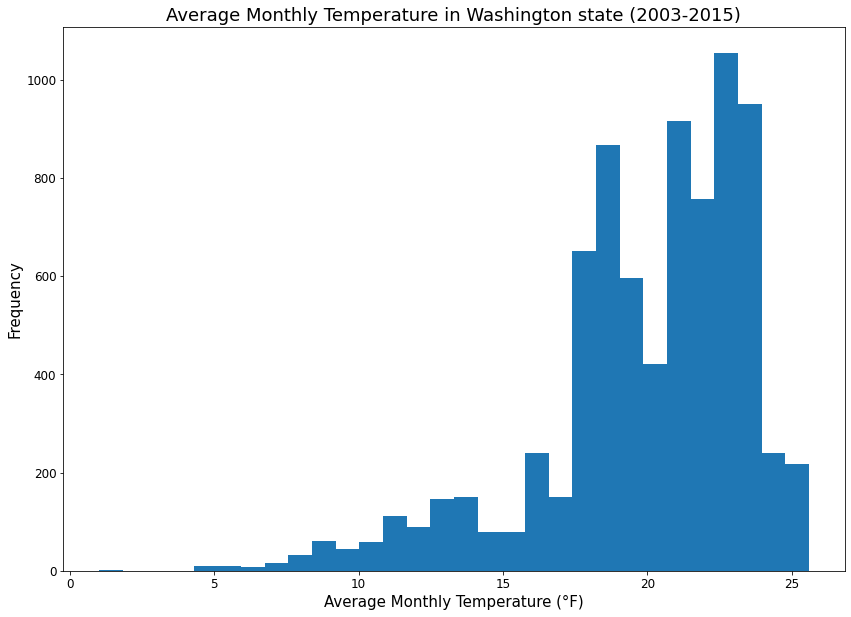

In [115]:
wa_temp = all_reg["T_MONTHLY_AVG"]

# Freedman-Diaconis rule: determining how many bins I should use in a histogram.
iqr = np.subtract(*np.percentile(wa_temp, [75, 25]))
bw = 2 * iqr * len(wa_temp)**(-1/3)
bin_count = int(round((max(wa_temp) - min(wa_temp)) / bw))

# Histogram
hist_temp = wa_temp.hist(bins=(bin_count-30), figsize=(14,10), grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("Average Monthly Temperature (°F)", fontsize=15);
plt.ylabel("Frequency", fontsize=15);
plt.title("Average Monthly Temperature in Washington state (2003-2015)", fontsize=18);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e25329a60>]],
      dtype=object)

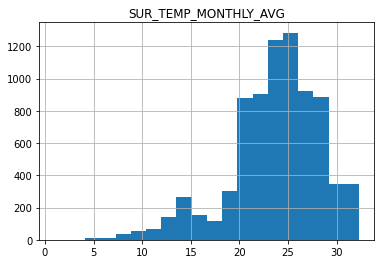

In [60]:
# Get Histo of monthly surface temp average
all_reg.hist(column="SUR_TEMP_MONTHLY_AVG", bins=20)

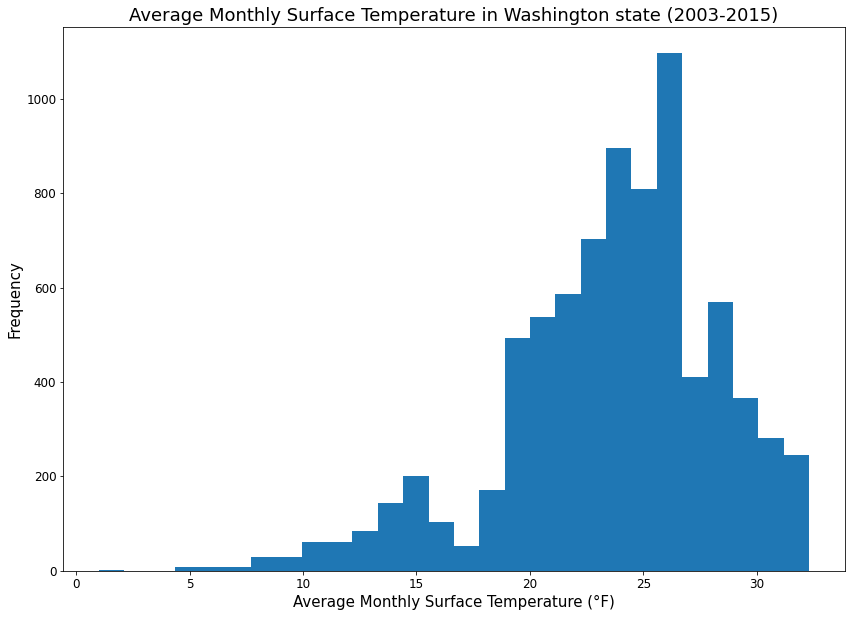

In [122]:
wa_surtemp = all_reg["SUR_TEMP_MONTHLY_AVG"]

# Freedman-Diaconis rule: determining how many bins I should use in a histogram.
iqr = np.subtract(*np.percentile(wa_surtemp, [75, 25]))
bw = 2 * iqr * len(wa_surtemp)**(-1/3)
bin_count = int(round((max(wa_surtemp) - min(wa_surtemp)) / bw))

# Histogram
hist_temp = wa_surtemp.hist(bins=(bin_count-30), figsize=(14,10), grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("Average Monthly Surface Temperature (°F)", fontsize=15);
plt.ylabel("Frequency", fontsize=15);
plt.title("Average Monthly Surface Temperature in Washington state (2003-2015)", fontsize=18);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e25205fd0>]],
      dtype=object)

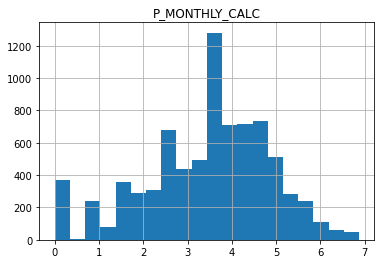

In [61]:
# Get Histo of monthly precipitation average
all_reg.hist(column="P_MONTHLY_CALC", bins=20)

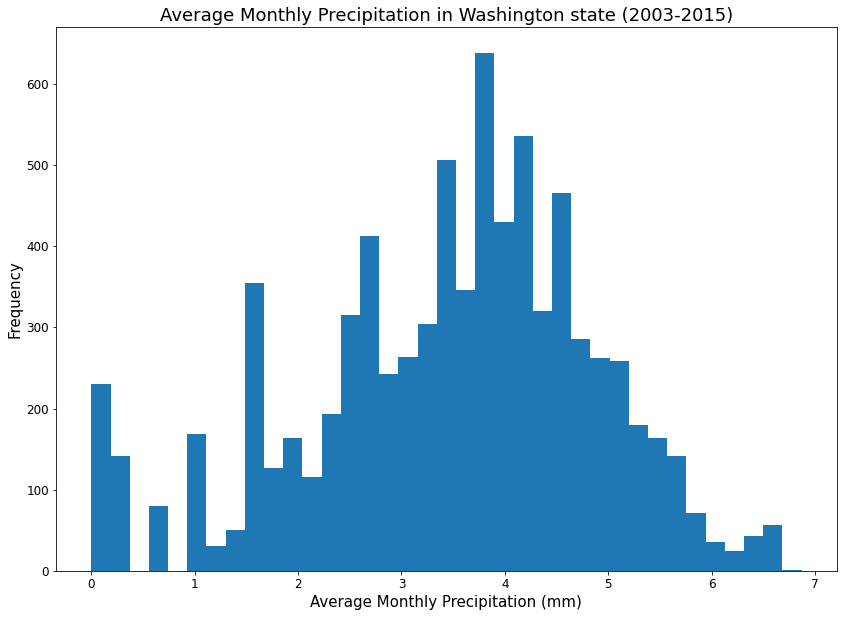

In [119]:
wa_p = all_reg["P_MONTHLY_CALC"]

# Freedman-Diaconis rule: determining how many bins I should use in a histogram.
iqr = np.subtract(*np.percentile(wa_p, [75, 25]))
bw = 2 * iqr * len(wa_p)**(-1/3)
bin_count = int(round((max(wa_p) - min(wa_p)) / bw))

# Histogram
hist_temp = wa_p.hist(bins=(bin_count), figsize=(14,10), grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("Average Monthly Precipitation (mm)", fontsize=15);
plt.ylabel("Frequency", fontsize=15);
plt.title("Average Monthly Precipitation in Washington state (2003-2015)", fontsize=18);

In [123]:
# check correlation among each feature
prt_one_corr = all_reg[["T_MONTHLY_AVG","SUR_TEMP_MONTHLY_AVG","P_MONTHLY_CALC"]].corr()
prt_one_corr

T_MONTHLY_AVG  SUR_TEMP_MONTHLY_AVG  P_MONTHLY_CALC
T_MONTHLY_AVG              1.000000              0.944330       -0.463459
SUR_TEMP_MONTHLY_AVG       0.944330              1.000000       -0.546018
P_MONTHLY_CALC            -0.463459             -0.546018        1.000000

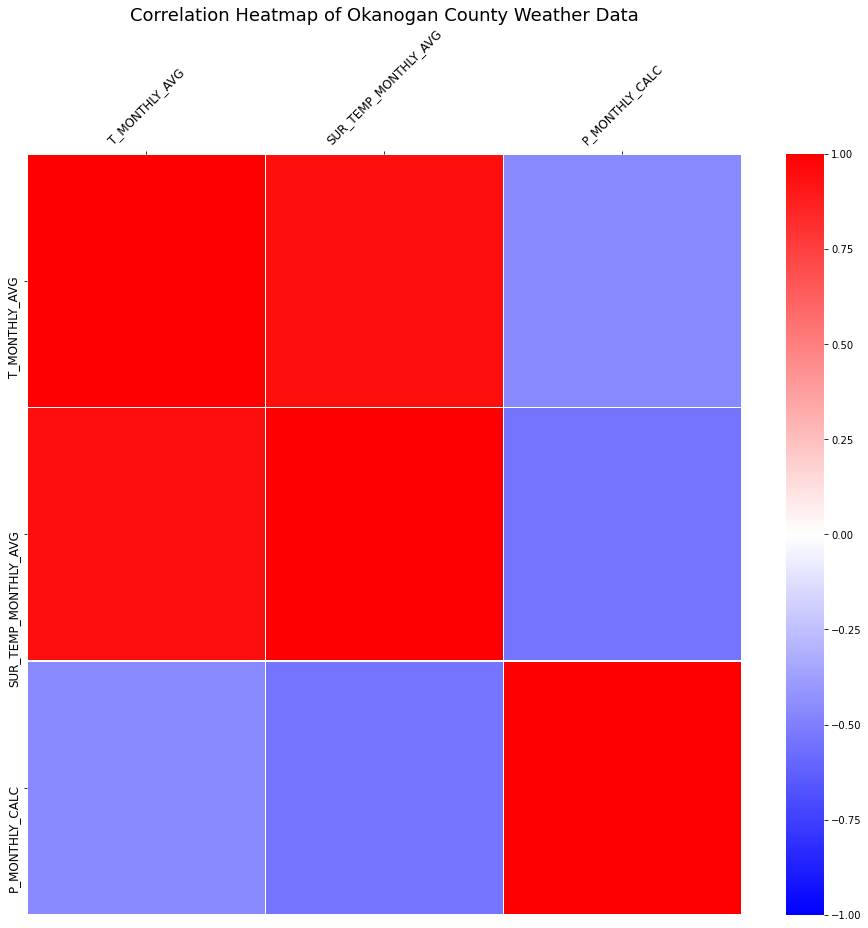

In [114]:
plt.figure(figsize=(16,14))
sns.heatmap(prt_one_corr, vmax=1., vmin=-1., center=0, linewidths=.5, cmap='bwr').xaxis.tick_top()
plt.tick_params(labelsize=12)
plt.xticks(rotation=45);
plt.title("Correlation Heatmap of Okanogan County Weather Data", fontsize=18);

In [63]:
# Use Gaussian NB classifer for all 3 features
scores = []
for i in range(100):
    train, test = train_test_split(all_reg[["T_MONTHLY_AVG","P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG","FIRE_SIZE_CLASS"]], test_size=0.2)
    cnb = GaussianNB()
    cnb.fit(train[["T_MONTHLY_AVG","P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], train["FIRE_SIZE_CLASS"])
    scores.append(cnb.score(test[["T_MONTHLY_AVG","P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], test["FIRE_SIZE_CLASS"]))

    mean(scores)

In [64]:
# Use Gaussian NB classifer for only 2 features monthly precipitation ave and monthly temp ave
scores = []
for i in range(100):
    train, test = train_test_split(all_reg[["T_MONTHLY_AVG","P_MONTHLY_CALC","FIRE_SIZE_CLASS"]], test_size=0.2)
    cnb = GaussianNB()
    cnb.fit(train[["T_MONTHLY_AVG","P_MONTHLY_CALC"]], train["FIRE_SIZE_CLASS"])
    scores.append(cnb.score(test[["T_MONTHLY_AVG","P_MONTHLY_CALC"]], test["FIRE_SIZE_CLASS"]))
#accuracy of classifires predictions on the test set
mean(scores)

0.6697550251256281

In [65]:
# Use Gaussian NB classifer for 2 features features monthly precipitation ave and monthly surface temp ave
scores = []
for i in range(100):
    train, test = train_test_split(all_reg[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG","FIRE_SIZE_CLASS"]], test_size=0.2)
    cnb = GaussianNB()
    cnb.fit(train[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], train["FIRE_SIZE_CLASS"])
    scores.append(cnb.score(test[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], test["FIRE_SIZE_CLASS"]))
mean(scores)

0.6725062814070352

In [66]:
# Use Multinomial NB classifer for 2 features features monthly precipitation ave and monthly surface temp ave
scores = []
for i in range(100):
    train, test = train_test_split(all_reg[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG","FIRE_SIZE_CLASS"]], test_size=0.2)
    cnb = MultinomialNB()
    cnb.fit(train[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], train["FIRE_SIZE_CLASS"])
    scores.append(cnb.score(test[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], test["FIRE_SIZE_CLASS"]))
mean(scores)

0.6734924623115578

In [67]:
# Use Complement NB classifer for 2 features features monthly precipitation ave and monthly surface temp ave
scores = []
for i in range(100):
    train, test = train_test_split(all_reg[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG","FIRE_SIZE_CLASS"]], test_size=0.2)
    cnb = ComplementNB()
    cnb.fit(train[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], train["FIRE_SIZE_CLASS"])
    scores.append(cnb.score(test[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], test["FIRE_SIZE_CLASS"]))
mean(scores)

0.3699183417085427

In [68]:
# Use Bernoulli NB classifer for 2 features features monthly precipitation ave and monthly surface temp ave
scores = []
for i in range(100):
    train, test = train_test_split(all_reg[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG","FIRE_SIZE_CLASS"]], test_size=0.2)
    cnb = BernoulliNB()
    cnb.fit(train[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], train["FIRE_SIZE_CLASS"])
    scores.append(cnb.score(test[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], test["FIRE_SIZE_CLASS"]))
mean(scores)

0.6761620603015075

In [69]:
# Use Categorical NB classifer for 2 features features monthly precipitation ave and monthly surface temp ave
scores = []
for i in range(100):
    train, test = train_test_split(all_reg[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG","FIRE_SIZE_CLASS"]], test_size=0.2)
    cnb = CategoricalNB()
    cnb.fit(train[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], train["FIRE_SIZE_CLASS"])
    scores.append(cnb.score(test[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], test["FIRE_SIZE_CLASS"]))
mean(scores)

0.6723869346733669

In [70]:
train, test = train_test_split(all_reg[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG","FIRE_SIZE_CLASS"]], test_size=0.2)
mnb = MultinomialNB()
mnb.fit(train[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], train["FIRE_SIZE_CLASS"])
mnb.score(test[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], test["FIRE_SIZE_CLASS"])

0.6790201005025126

In [36]:
# Get Probabilites of each feature
probs = np.exp(mnb.predict_log_proba(test[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]]))

In [37]:
print(probs)

[[0.67705728 0.25213144 0.03739211 ... 0.00727346 0.00960855 0.00660508]
 [0.67421067 0.26012806 0.02863555 ... 0.01197062 0.01047957 0.00661555]
 [0.67687398 0.2532625  0.03610039 ... 0.00778407 0.00972392 0.00660842]
 ...
 [0.67706736 0.25104814 0.03868689 ... 0.00688023 0.00950388 0.00660048]
 [0.67641788 0.25554712 0.03351757 ... 0.00886931 0.00995999 0.00661443]
 [0.67673092 0.25333627 0.03605704 ... 0.00789876 0.00973609 0.00660752]]


In [124]:
# final naive bayes
scores = []
for i in range(100):
    train, test = train_test_split(all_reg[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG","FIRE_SIZE_CLASS"]], test_size=0.25, stratify=all_reg["FIRE_SIZE_CLASS"])
    cnb = ComplementNB()
    cnb.fit(train[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], train["FIRE_SIZE_CLASS"])
    scores.append(cnb.score(test[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]], test["FIRE_SIZE_CLASS"]))
score = mean(scores)

In [39]:
probs2 = np.exp(cnb.predict_log_proba(test[["P_MONTHLY_CALC","SUR_TEMP_MONTHLY_AVG"]]))

In [40]:
print(probs2)

[[0.14340881 0.14238546 0.14317336 ... 0.14265955 0.14271155 0.14275893]
 [0.1431955  0.14257093 0.14304991 ... 0.14273606 0.14276757 0.14279633]
 [0.14404325 0.14183701 0.1435393  ... 0.1424321  0.14254464 0.14264708]
 ...
 [0.14238678 0.14327437 0.14258178 ... 0.14302614 0.14297995 0.14293811]
 [0.14551659 0.14057394 0.14438504 ... 0.1419043  0.14215612 0.14238541]
 [0.14385063 0.14200451 0.14342781 ... 0.1425012  0.14259523 0.14268086]]


In [41]:
(score - 1/7)*100

20.77109818286289

In [42]:
score

0.35056812468577175

In [43]:
median(scores)

0.4622926093514329

# Part Two
## Classification of Okanogan County, WA

In [72]:
# WARNING: Large data set.
f = pd.read_csv('Fires.csv', low_memory=False)
f = f[f['STATE'] == 'WA']

In [73]:
# Get only fires iwth FIPS_CODE 47.0 == OKanogan County
ok_county = f[f['FIPS_CODE'] == 47.0]
# GET only attributes that I want to use, dropna()
ok_county = ok_county[['LATITUDE', 'LONGITUDE','FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIPS_CODE', 'FIPS_NAME', 'DISCOVERY_DATE']].dropna()
# ADD new column for YearMonth format
ok_county['LST_YRMO'] = ok_county['DISCOVERY_DATE'].apply(get_yrmo)
# DROP discovery data column
ok_county = ok_county.drop('DISCOVERY_DATE', axis=1)

In [74]:
# Delete dataframe with all country fires, to peserve memory in python
del f

In [75]:
# OPEN new windspeed, humidity, temperature monthly average data from OKanogan county fires
ok_wspd = pd.read_csv('ok_wspd.csv', low_memory=False)
ok_hum = pd.read_csv('ok_hum.csv', low_memory=False)
ok_temp = pd.read_csv('ok_temp.csv', low_memory=False)

In [76]:
# MERGE all three dataframes into one 
ok_county = pd.merge(ok_county, ok_wspd, on=['LST_YRMO','LST_YRMO'])
ok_county = pd.merge(ok_county, ok_hum, on=['LST_YRMO','LST_YRMO'])
ok_county = pd.merge(ok_county, ok_temp, on=['LST_YRMO','LST_YRMO'])

In [77]:
#ok_county.to_csv('ok_county.csv')
ok_county.head(5)

LATITUDE   LONGITUDE  FIRE_SIZE FIRE_SIZE_CLASS  FIPS_CODE FIPS_NAME  \
0  46.774444 -121.064722       1.00               B       47.0  Okanogan   
1  48.647020 -119.633400       1.50               B       47.0  Okanogan   
2  48.367350 -119.725600       0.10               A       47.0  Okanogan   
3  48.312778 -120.277222       0.01               A       47.0  Okanogan   
4  48.647222 -119.787778       0.25               A       47.0  Okanogan   

   LST_YRMO  WSPD_MONTHLY_AVG  HUM_MONTHLY_AVG  TEMP_MONTHLY_AVG  
0    200503          4.536010             60.8            44.492  
1    200503          4.536010             60.8            44.492  
2    200503          4.536010             60.8            44.492  
3    200508          4.598147             40.4            72.176  
4    200508          4.598147             40.4            72.176

In [78]:
# create list of all possible fire class sizes
class_set = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
# find the frequency of fire classes in OKanogan County
class_freq = [(fire_class, len(ok_county[ok_county['FIRE_SIZE_CLASS'] == fire_class])) for fire_class in class_set]
print(class_freq)

[('A', 1539), ('B', 750), ('C', 137), ('D', 29), ('E', 25), ('F', 24), ('G', 20)]


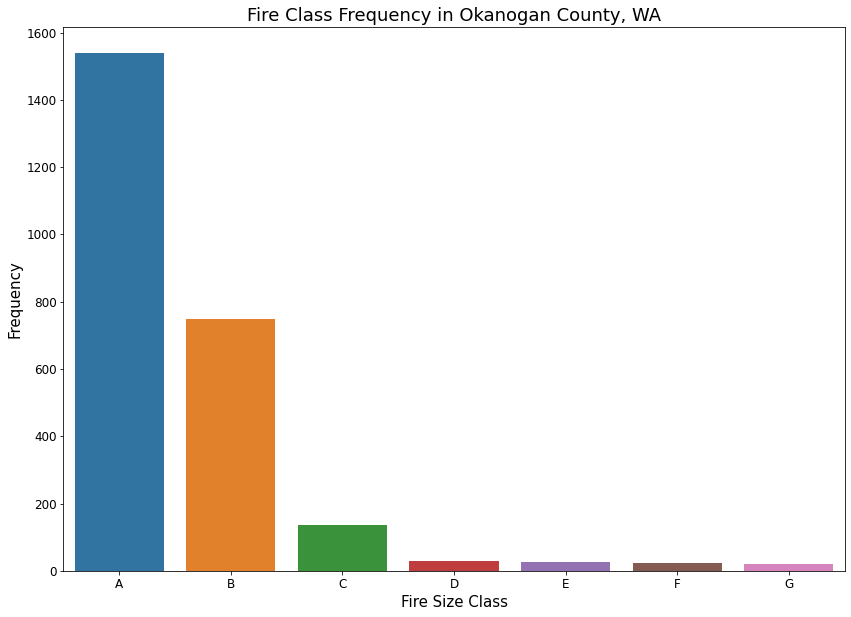

In [79]:
# create plot of frequencies of each class
plt.figure(figsize=(14,10))
sns.countplot(x = 'FIRE_SIZE_CLASS', data = ok_county, order = class_set)
plt.tick_params(labelsize=12)
plt.xlabel("Fire Size Class", fontsize=15);
plt.ylabel("Frequency",fontsize=15);
plt.title("Fire Class Frequency in Okanogan County, WA", fontsize=18);
plt.show()

In [80]:
# calculate relative frequencie of each class
class_rel_freq = [(fire_class, round(len(ok_county[ok_county['FIRE_SIZE_CLASS'] == fire_class]) / 2524, 4)) for fire_class in class_set]
print(class_rel_freq)

[('A', 0.6097), ('B', 0.2971), ('C', 0.0543), ('D', 0.0115), ('E', 0.0099), ('F', 0.0095), ('G', 0.0079)]


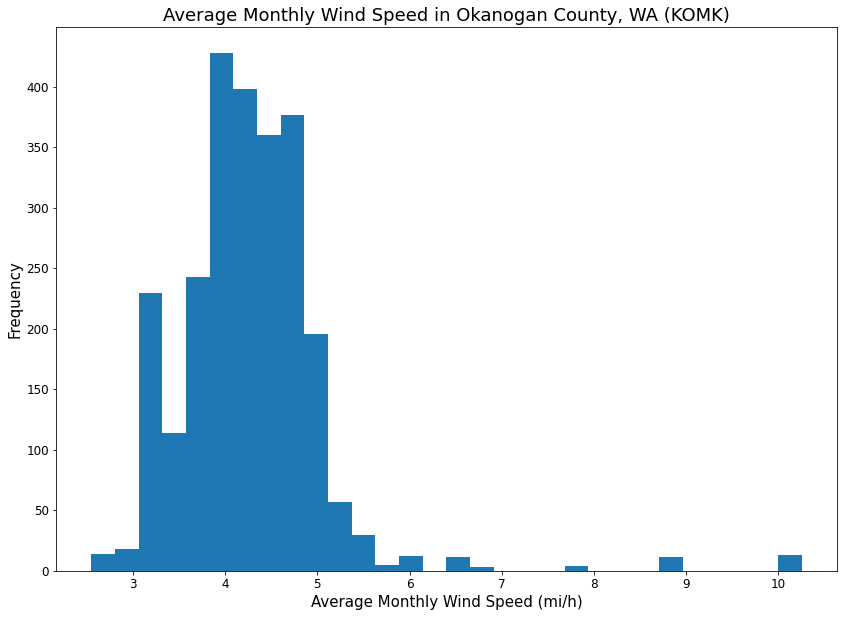

In [81]:
# HIST of wind speed monthly average in OK county
#ok_county.hist(column="WSPD_MONTHLY_AVG", bins=30)
ok_wspd = ok_county["WSPD_MONTHLY_AVG"]

# Freedman-Diaconis rule: determining how many bins I should use in a histogram.
iqr = np.subtract(*np.percentile(ok_wspd, [75, 25]))
bw = 2 * iqr * len(ok_wspd)**(-1/3)
bin_count = int(round((max(ok_wspd) - min(ok_wspd)) / bw))

# Histogram
hist_temp = ok_wspd.hist(bins=(bin_count-30), figsize=(14,10), grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("Average Monthly Wind Speed (mi/h)", fontsize=15);
plt.ylabel("Frequency", fontsize=15);
plt.title("Average Monthly Wind Speed in Okanogan County, WA (KOMK)", fontsize=18);

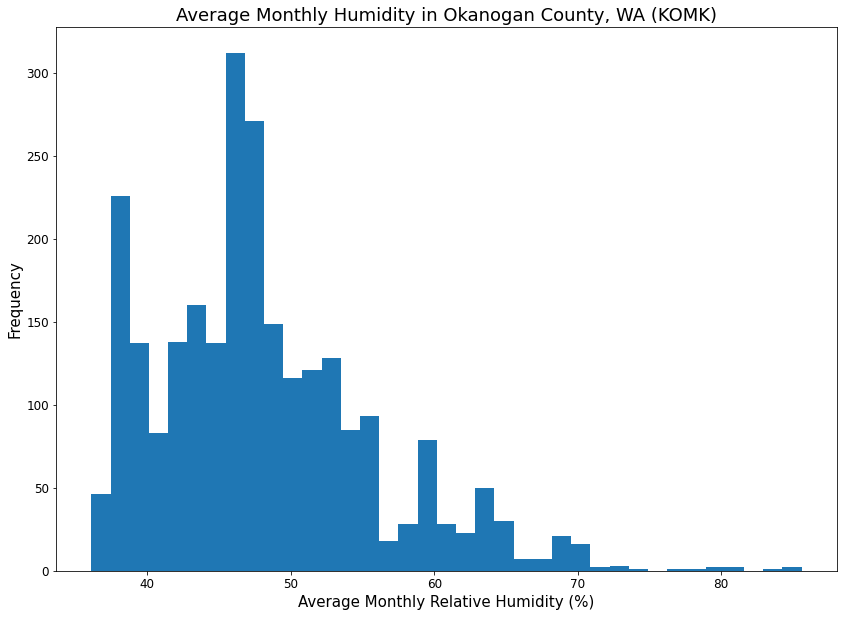

In [82]:
# HIST of humidity monthly average in OK county
#ok_county.hist(column="HUM_MONTHLY_AVG", bins=30)
ok_hum = ok_county["HUM_MONTHLY_AVG"]

# Freedman-Diaconis rule: determining how many bins I should use in a histogram.
iqr = np.subtract(*np.percentile(ok_hum, [75, 25]))
bw = 2 * iqr * len(ok_hum)**(-1/3)
bin_count = int(round((max(ok_hum) - min(ok_hum)) / bw))

# Histogram
hist_temp = ok_hum.hist(bins=bin_count, figsize=(14,10), grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("Average Monthly Relative Humidity (%)", fontsize=15);
plt.ylabel("Frequency", fontsize=15);
plt.title("Average Monthly Humidity in Okanogan County, WA (KOMK)", fontsize=18);

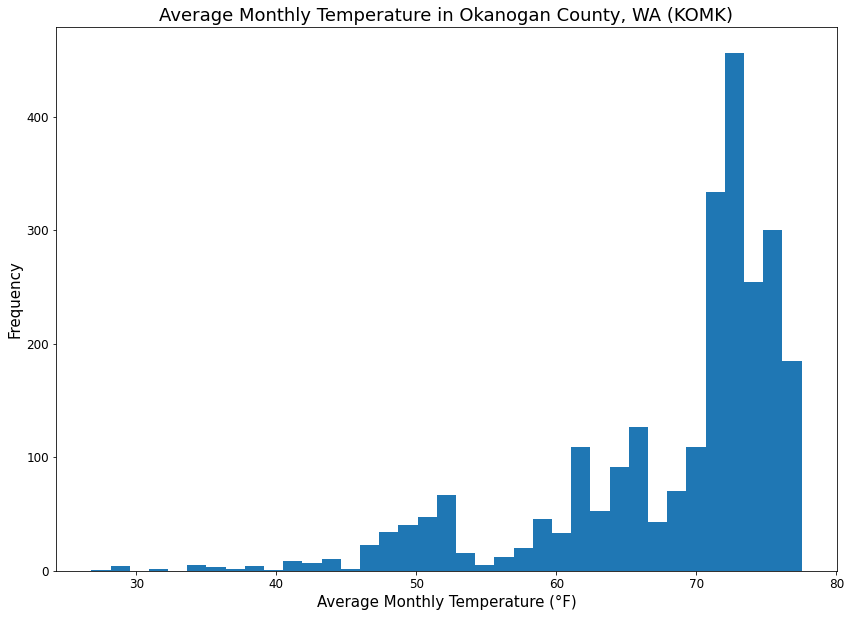

In [83]:
# HIST of temperature average in OK county
#ok_county.hist(column="TEMP_MONTHLY_AVG", bins=30)
ok_temp = ok_county["TEMP_MONTHLY_AVG"]

# Freedman-Diaconis rule: determining how many bins I should use in a histogram.
iqr = np.subtract(*np.percentile(ok_temp, [75, 25]))
bw = 2 * iqr * len(ok_temp)**(-1/3)
bin_count = int(round((max(ok_temp) - min(ok_temp)) / bw))

# Histogram
hist_temp = ok_temp.hist(bins=bin_count, figsize=(14,10), grid=False)
plt.tick_params(labelsize=12)
plt.xlabel("Average Monthly Temperature (°F)", fontsize=15);
plt.ylabel("Frequency", fontsize=15);
plt.title("Average Monthly Temperature in Okanogan County, WA (KOMK)", fontsize=18);

In [84]:
# correlation matric of all three attributes
corrmat = ok_county[["WSPD_MONTHLY_AVG","HUM_MONTHLY_AVG","TEMP_MONTHLY_AVG"]].corr()
corrmat

WSPD_MONTHLY_AVG  HUM_MONTHLY_AVG  TEMP_MONTHLY_AVG
WSPD_MONTHLY_AVG          1.000000        -0.339783         -0.039525
HUM_MONTHLY_AVG          -0.339783         1.000000         -0.613477
TEMP_MONTHLY_AVG         -0.039525        -0.613477          1.000000

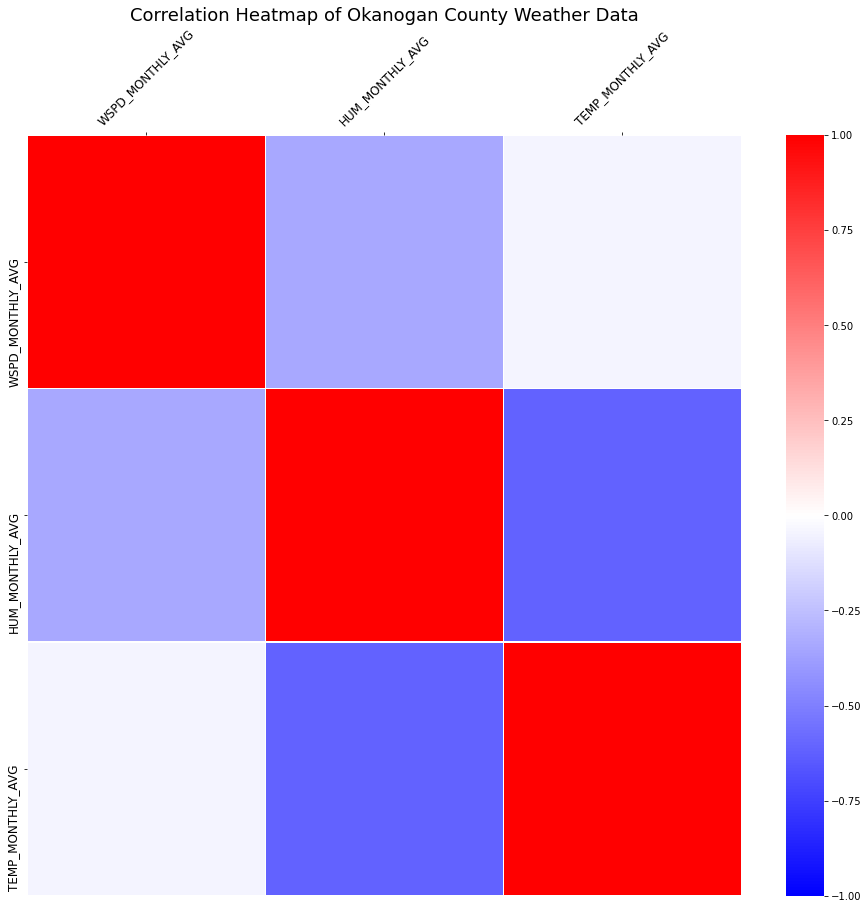

In [85]:
plt.figure(figsize=(16,14))
sns.heatmap(corrmat, vmax=1., vmin=-1., center=0, linewidths=.5, cmap='bwr').xaxis.tick_top()
plt.tick_params(labelsize=12)
plt.xticks(rotation=45);
plt.title("Correlation Heatmap of Okanogan County Weather Data", fontsize=18);

In [86]:
# Classifier input: X = predictors, Y = classes.
X = ok_county[["WSPD_MONTHLY_AVG","HUM_MONTHLY_AVG","TEMP_MONTHLY_AVG"]]
Y = ok_county["FIRE_SIZE_CLASS"]

# Baseline comparison: How good is random guessing?
baseline = round(100/7, 4)
print('We expect ' + str(baseline) + '% accuracy with random guessing.')

We expect 14.2857% accuracy with random guessing.


In [98]:
# Decision tree cross validated with 4-fold validation.
tree = DecisionTreeClassifier()
scores = cross_val_score(tree, X, Y, cv=4)
print('Scores: ' + str(scores) + '\nMean accuracy: ' + str(round(mean(scores)*100,4)) + '%')
print('+' + str(round(mean(scores) * 100 - baseline, 4)) + '% improvement')

Scores: [0.42155309 0.30269414 0.34865293 0.36450079]
Mean accuracy: 35.935%
+21.6493% improvement


In [88]:
# LOWER ACCURACY MEANS MORE LIKELY TO PREDICT LARGE FIRE
# MORE IMPORTANT: RARELY UNDERPREDICTS LARGE FIRES!
tree = DecisionTreeClassifier(class_weight='balanced')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle = True, stratify = Y, test_size=0.25)
tree.fit(X_train, Y_train)
score = tree.score(X_test, Y_test)
print(score)

0.27099841521394613


In [89]:
# NOTE: CLASS G HAS HIGH RECALL, MEANING HIGHLY SENSITIVE IN PREDICTING BIG FIRES
print(classification_report(Y_test, tree.predict(X_test), target_names=class_set))

              precision    recall  f1-score   support

           A       0.74      0.31      0.44       385
           B       0.46      0.19      0.27       188
           C       0.10      0.26      0.14        34
           D       0.03      0.29      0.06         7
           E       0.01      0.17      0.02         6
           F       0.02      0.17      0.03         6
           G       0.03      0.60      0.06         5

    accuracy                           0.27       631
   macro avg       0.20      0.28      0.15       631
weighted avg       0.60      0.27      0.36       631



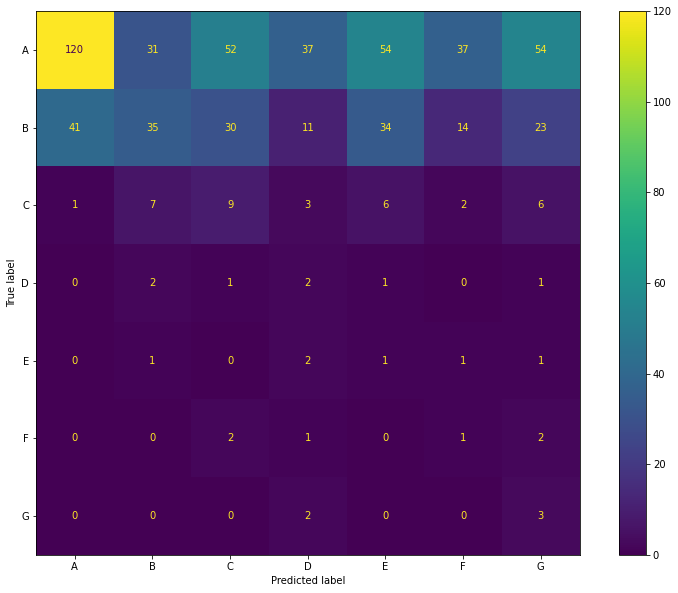

In [91]:
# confusion matrix of decision tree
fig, ax = plt.subplots(figsize=(14, 10))
plot_confusion_matrix(tree, X_test, Y_test, ax=ax)

In [66]:
# Complement naive Bayes cross validated with 4-fold validation.
# VERY BIASED TOWARDS LOWER CLASSES. TOO CONSERVATIVE WITH PREDICTIONS.
# NB FAILS TO PREDICT LARGE FIRES RELIABLY.
cnb = ComplementNB()
scores = cross_val_score(cnb, X, Y, cv=4)
print('Scores: ' + str(scores) + '\nMean accuracy: ' + str(round(mean(scores)*100,4)) + '%')
print('+' + str(round(mean(scores) * 100 - baseline, 4)) + '% improvement')

Scores: [0.59429477 0.4881141  0.47543582 0.50871632]
Mean accuracy: 51.664%
+37.3783% improvement


In [107]:
# TESTING
# Issues reliably predicting large fires. Very rare. Large data imbalance -> not enough large fires.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle = True, stratify = Y, test_size=0.25)
cnb.fit(X_train, Y_train)
Y_pred = cnb.predict(X_test)


# classification report of complement ND classifier
print(classification_report(Y_test, Y_pred, target_names=class_set))
#confusion_matrix(Y_test, Y_pred, labels=class_set)

              precision    recall  f1-score   support

           A       0.63      0.91      0.75       385
           B       0.39      0.14      0.21       188
           C       0.17      0.03      0.05        34
           D       0.00      0.00      0.00         7
           E       0.00      0.00      0.00         6
           F       0.00      0.00      0.00         6
           G       0.00      0.00      0.00         5

    accuracy                           0.60       631
   macro avg       0.17      0.15      0.14       631
weighted avg       0.51      0.60      0.52       631



/home/jessy/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


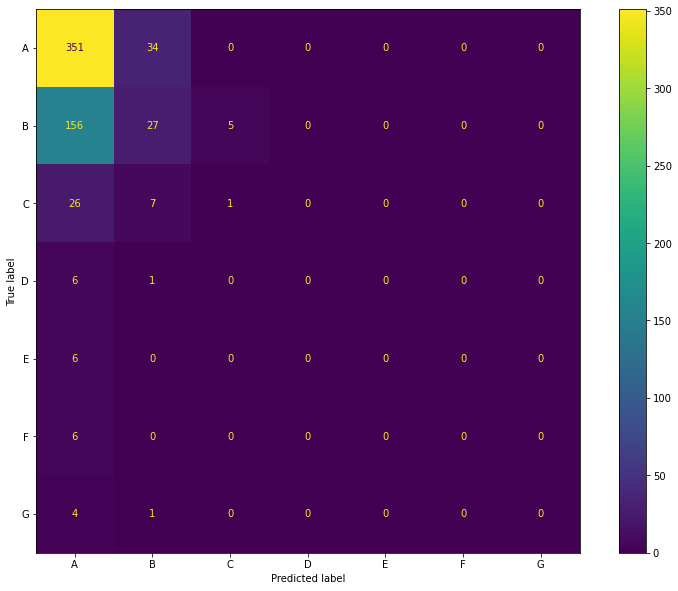

In [108]:
### confusion matrix of complement ND classifier
fig, ax = plt.subplots(figsize=(14, 10))
plot_confusion_matrix(cnb, X_test, Y_test, ax=ax)

# Additional testing of complement NB

In [21]:
# NO WIND
cnb = ComplementNB()
scores = cross_val_score(cnb, ok_county[["HUM_MONTHLY_AVG","TEMP_MONTHLY_AVG"]], Y, cv=4)
print('Scores: ' + str(scores) + '\nMean accuracy: ' + str(round(mean(scores)*100,4)) + '%')
print('+' + str(round(mean(scores) * 100 - baseline, 4)) + '% improvement')

Scores: [0.59429477 0.4881141  0.48177496 0.4770206 ]
Mean accuracy: 51.0301%
+36.7444% improvement


In [22]:
# NO HUMIDITY
# Expected to be very good
cnb = ComplementNB()
scores = cross_val_score(cnb, ok_county[["WSPD_MONTHLY_AVG","TEMP_MONTHLY_AVG"]], Y, cv=4)
print('Scores: ' + str(scores) + '\nMean accuracy: ' + str(round(mean(scores)*100,4)) + '%')
print('+' + str(round(mean(scores) * 100 - baseline, 4)) + '% improvement')

Scores: [0.44690967 0.58161648 0.39302694 0.62282092]
Mean accuracy: 51.1094%
+36.8237% improvement


In [23]:
# NO TEMP
cnb = ComplementNB()
scores = cross_val_score(cnb, ok_county[["HUM_MONTHLY_AVG","WSPD_MONTHLY_AVG"]], Y, cv=4)
print('Scores: ' + str(scores) + '\nMean accuracy: ' + str(round(mean(scores)*100,4)) + '%')
print('+' + str(round(mean(scores) * 100 - baseline, 4)) + '% improvement')

Scores: [0.318542   0.11251981 0.41045959 0.1933439 ]
Mean accuracy: 25.8716%
+11.5859% improvement


In [24]:
# ONLY TEMP
# Best result? No. Predicts ALL fires to be class A.
cnb = ComplementNB()
scores = cross_val_score(cnb, ok_county[["HUM_MONTHLY_AVG"]], Y, cv=4)
print('Scores: ' + str(scores) + '\nMean accuracy: ' + str(round(mean(scores)*100,4)) + '%')
print('+' + str(round(mean(scores) * 100 - baseline, 4)) + '% improvement')

Scores: [0.61014263 0.60855784 0.61014263 0.61014263]
Mean accuracy: 60.9746%
+46.6889% improvement


In [63]:
# Just guesses class A, and 60.97 % of the data is class A.
# NOT USEFUL
cnb = ComplementNB()
train, test = train_test_split(ok_county[["TEMP_MONTHLY_AVG","FIRE_SIZE_CLASS"]], test_size=0.4)
cnb.fit(train[["TEMP_MONTHLY_AVG"]], train["FIRE_SIZE_CLASS"])
print(cnb.predict_proba(test[["TEMP_MONTHLY_AVG"]])[3])

[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]


In [123]:
# Complement naive Bayes with random (75/25) training/test split.
# Counting prediction frequencies of each class.
c_list = []
for i in range(1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle = True,
                                                    stratify=Y, 
                                                    test_size=0.25)
    cnb = ComplementNB()
    cnb.fit(X_train, Y_train)
    arr = cnb.predict_proba(X_test)
    c_list += [np.argmax(p) for p in arr]

cvec = np.array(c_list)
cfreq = np.array([sum(cvec == i) for i in range(len(class_set))])
cfreq = np.log(cfreq + 1)
#cfreq = cfreq / sum(cfreq) * 100
print(cfreq)
# What classes are predicted?
#df = pd.DataFrame(c_list, columns =['FIRE_SIZE_CLASS'])
#df.head(10)

[12.89803162 12.34742463  6.76157277  1.60943791  0.          5.43807931
  2.77258872]


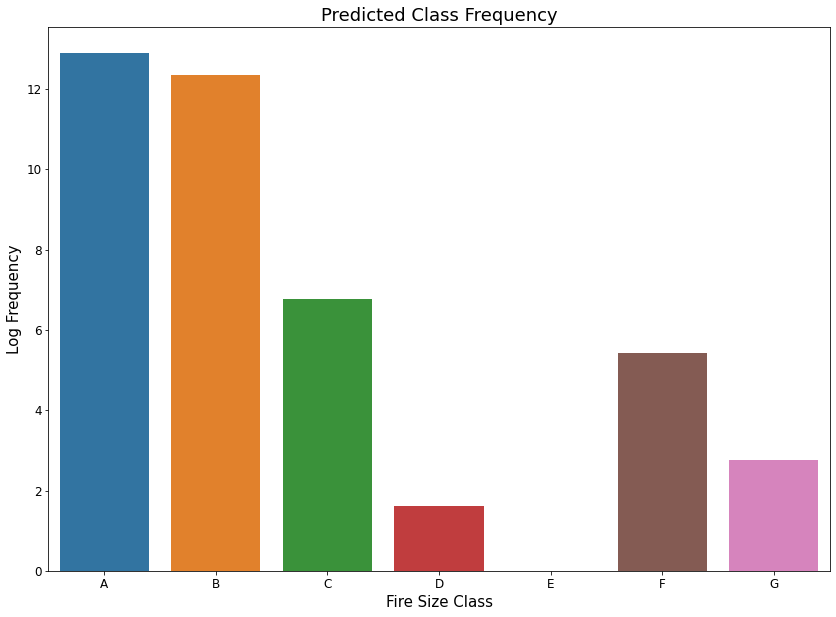

In [124]:
# create plot
plt.figure(figsize=(14,10))
sns.barplot(x = class_set, y = cfreq, orient = 'v')
plt.tick_params(labelsize=12)
plt.xlabel("Fire Size Class", fontsize=15);
plt.ylabel("Log Frequency",fontsize=15);
plt.title("Predicted Class Frequency", fontsize=18);
plt.show()

In [375]:
factors = [num if 2524 % num == 0 else 1 for num in range(2,2524//2)]

In [376]:
set(factors)

{1, 2, 4, 631}